In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface, get_fixed_boundary_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
rod_length = 0.09026509716852701
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('clam_1', thickness, width, weaving_dir)

0.022566274292131754 0.0015796392004492226


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

### Initialization

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=elastic_rods.InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
# curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
# set_surface_view_options(curved_linkage_view)
# curved_linkage_view.show()

In [6]:
# curved_linkage.setExtendedDoFsPSRL(np.load('results/clam_1/clam_1_dof.npy'))

In [7]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B

In [8]:
curved_linkage.joint(668).type = get_opposite_joint_type(curved_linkage.joint(668).type)

### Gradually increase the width for stage 1

In [9]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()

In [10]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [11]:
curved_linkage_view.update(scalarField=colors)

In [12]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [13]:
curved_linkage.attraction_weight = 1e-5

In [14]:
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width * 0.5], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)

In [13]:
fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [14]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint

In [15]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [16]:
curved_linkage.attraction_weight = 1e-7

In [17]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	6.30331e-06	9.87378e-08	9.87378e-08	0	0


In [7]:
import pickle 
import gzip
# pickle.dump(curved_linkage, gzip.open('{}_stage_1.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [8]:
curved_linkage = pickle.load(gzip.open('{}_stage_2_e3.pkl.gz'.format(io.MODEL_NAME), 'r'))

In [9]:
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [12]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [13]:
curved_linkage_view.update(scalarField=colors)

In [11]:
curved_linkage.scaleJointWeights(0.1, 100, [303, 675, 302, 603, 668, 602])

In [13]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, fixed_boundary_joint = fixed_boundary_joints, inner_gradTol = 1e-7)

In [ ]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, 0.03302674639566293, -5, 2)

rl_regularization_weight 1.0
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0


In [ ]:
import pickle 
import gzip
pickle.dump(curved_linkage, gzip.open('{}_stage_2_e5.pkl.gz'.format(io.MODEL_NAME), 'w'))
# pickle.load(gzip.open('hemoglobin_three_stages_results/hemoglobin_contact_opt_2020_1201.pkl.gz', 'r'))

In [14]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
# elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

Computing negative curvature direction for scaled tau = 0.0117245
Spectra unsuccessful after 9 iterations
Negative curvature direction calculation failed
0	6.30331e-06	7.1301e-05	7.1301e-05	1	1


### Validation

In [ ]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [ ]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [ ]:
# double_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(double_view)
# double_view.show()

In [ ]:
# double_view.viewOptions[double_view.ViewType.SURFACE].color

In [34]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [35]:
get_average_distance_to_target_surface(curved_linkage)/io.RIBBON_CS[1]

0.11297115770333452

In [ ]:
# distance_to_surface = np.array(curved_linkage.get_squared_distance_to_target_surface((curved_linkage.visualizationGeometry()[0]).flatten()))


In [ ]:
# distance_to_surface = np.sqrt(distance_to_surface)

In [ ]:
# plt.plot(np.sort(distance_to_surface))


In [36]:
set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

Min Width  0.022566274292131754
Scale:  221.56958367484543
num seg per rod 38
num seg per rod 37
num seg per rod 28
num seg per rod 42
num seg per rod 30
num seg per rod 44
num seg per rod 33
num seg per rod 37
num seg per rod 25
num seg per rod 47
num seg per rod 33
num seg per rod 38
num seg per rod 25
num seg per rod 7
num seg per rod 45
num seg per rod 5
num seg per rod 19
num seg per rod 5
num seg per rod 7
num seg per rod 5
num seg per rod 19
num seg per rod 5
num seg per rod 25
num seg per rod 18
num seg per rod 28
num seg per rod 30
num seg per rod 33
num seg per rod 33
num seg per rod 33
num seg per rod 33
num seg per rod 18
num seg per rod 47
num seg per rod 37
num seg per rod 25
num seg per rod 32
num seg per rod 11
num seg per rod 44
num seg per rod 37
num seg per rod 21
num seg per rod 38
num seg per rod 32
num seg per rod 13
num seg per rod 21
num seg per rod 11
num seg per rod 25
num seg per rod 25
num seg per rod 25
num seg per rod 11
num seg per rod 11
num seg per rod 

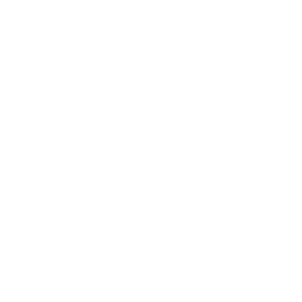

In [18]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

## Contact Optimization

In [ ]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

In [ ]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/clam_1/clam_1_dof.npy'))

In [ ]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [ ]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [ ]:
optimizer.setLinkageAttractionWeight(1e-5)

In [ ]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
# contact_optimization(optimizer, curved_linkage, curved_linkage_view, -1, 1e4)

In [ ]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()